In [1]:
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
from __future__ import division #for division

from matplotlib import pyplot
import matplotlib.pyplot as plt # para dibujar
%matplotlib inline

import statsmodels as sm
import sklearn as skl
import sklearn.preprocessing as preprocessing
import sklearn.linear_model as linear_model
import sklearn.cross_validation as cross_validation
import sklearn.metrics as metrics
import sklearn.tree as tree
import seaborn as sns

C:\Users\PC-CASA\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split, KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [3]:
# cargamos datos
censo = pd.read_csv("./census.csv") # cargamos fichero
# censo y mostramos las 5 primeras filas
censo.head(5)    # visualizamos 5 primeras filas

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


Antes de nada, quitamos los espacios en blanco que hay en todas los campos de texto.

In [4]:
censo = censo.replace('\s+', '', regex=True)

El primer paso es determinar cuánta gente hay en los dos grupos de la columna "income". Cuánta gente cobra <=50K y cuánta >50K.

In [5]:
# Número total de registros
numero_registros = censo.shape[0]

# Personas con ingresos > 50000K
mayor_50k = censo.income.value_counts()[1].astype(int)

# Personas cuyos ingresos <=50000K
menor_50k = censo.income.value_counts()[0].astype(int)

# Porcentaje de personas cuyos ingresos superan $50000;
porcentaje = mayor_50k / numero_registros

# Print the results
print ("Número total de registros: {}".format(numero_registros))
print ("Personas cuyos ingresos superan $50,000: {}".format(mayor_50k))
print ("Personas cuyos ingresos NO superan $50,000: {}".format(menor_50k))
print ("Porcentaje de personas cuyos ingresos superan $50,000: {:.2f}%".format(porcentaje * 100))

Número total de registros: 45222
Personas cuyos ingresos superan $50,000: 11208
Personas cuyos ingresos NO superan $50,000: 34014
Porcentaje de personas cuyos ingresos superan $50,000: 24.78%


In [6]:
# Vamos a obtener número de filas y columnas.
print(censo.shape)

(45222, 14)


In [7]:
#s Resumen de estadísticas
censo.describe().astype(int)

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222,45222,45222,45222,45222
mean,38,10,1101,88,40
std,13,2,7506,404,12
min,17,1,0,0,1
25%,28,9,0,0,40
50%,37,10,0,0,40
75%,47,13,0,0,45
max,90,16,99999,4356,99


In [8]:
print (censo.dtypes) # => tipo de datos

age                  int64
workclass           object
education_level     object
education-num      float64
marital-status      object
occupation          object
relationship        object
race                object
sex                 object
capital-gain       float64
capital-loss       float64
hours-per-week     float64
native-country      object
income              object
dtype: object


In [9]:
censo.isnull().values.any() # Buscamos si hay algún valor NA. En nuestro caso no lo hay.

False

Mostramos varias gráficas para intentar analizar mejor nuestro dataset.

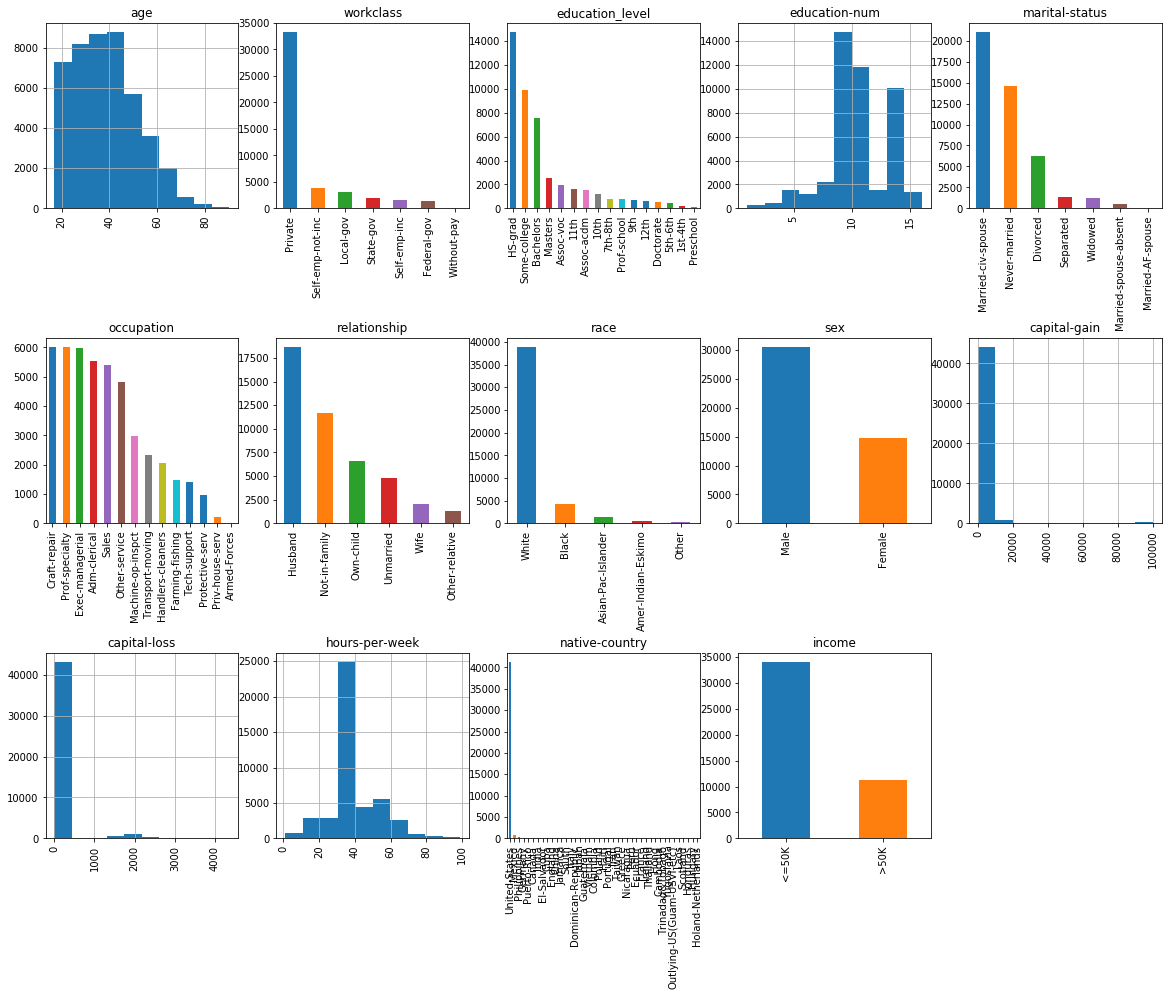

In [10]:
fig = plt.figure(figsize=(20,15))
cols = 5
filas = 3
for i, columna in enumerate(censo.columns):
    ax = fig.add_subplot(filas, cols, i + 1)
    ax.set_title(columna)
    if censo.dtypes[columna] == np.object:
        censo[columna].value_counts().plot(kind="bar", axes=ax)
    else:
        censo[columna].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

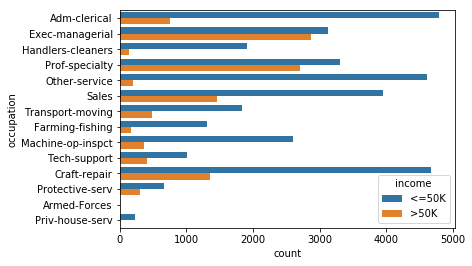

In [11]:
sns.countplot(y='occupation', hue='income', data=censo)

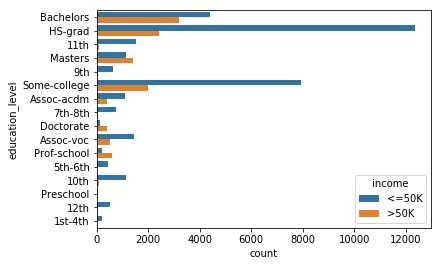

In [12]:
sns.countplot(y='education_level', hue='income', data=censo)

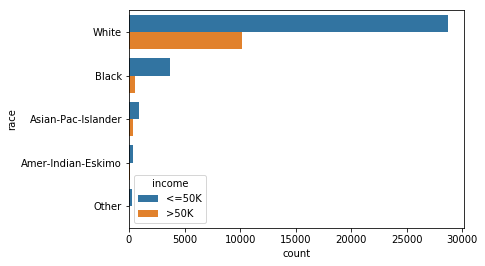

In [13]:
sns.countplot(y='race', hue='income', data=censo)

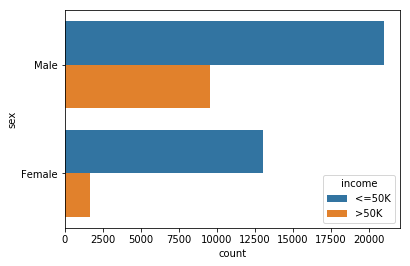

In [14]:
sns.countplot(y='sex', hue='income', data=censo)

Vamos a empezar a preparar nuestro dataset. Lo primero es ordenar la columna "income". Así si el valor "<=50K" le daremos valor cero. Si es ">50k", será un uno.

In [15]:
censo['income'] = censo['income'].apply(lambda x: 1 if x=='>50K' else 0) 

In [16]:
dff = censo # lo usaremos para las gráficas que veremos a continuación

In [17]:
censo.head(10)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,0
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,0
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,0
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,0
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,0
5,37,Private,Masters,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,0
6,49,Private,9th,5.0,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.0,0.0,16.0,Jamaica,0
7,52,Self-emp-not-inc,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,45.0,United-States,1
8,31,Private,Masters,14.0,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,50.0,United-States,1
9,42,Private,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178.0,0.0,40.0,United-States,1


Seguimos con la columna "native-country" en la que Estados Unidos absorve todos los datos. Vamos a verificarlo.

In [18]:
(censo["native-country"].value_counts() / censo.shape[0]).head()

United-States    0.913095
Mexico           0.019968
Philippines      0.006258
Germany          0.004268
Puerto-Rico      0.003870
Name: native-country, dtype: float64

Así, es Estados Unidos tiene un 91%. El segundo es México con menos de 2%. Vamos a agruparlos en EE.UU (1), resto del mundo (0).

In [19]:
censo['native-country'] = censo['native-country'].replace('United-States', 1) # Si el país es EE.UU = 1

In [20]:
censo.loc[censo['native-country'] != 1 , 'native-country'] = 0 # Resto de países = 0

In [21]:
censo.head(5)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,1,0
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,1,0
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,1,0
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,1,0
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,0,0


Usamos "get-dummies" para convertir en numéricas nuestras características.

In [22]:
censo = pd.concat([censo, pd.get_dummies(censo['workclass'],prefix='workclass',prefix_sep=':')], axis=1)
censo.drop('workclass',axis=1,inplace=True)

censo = pd.concat([censo, pd.get_dummies(censo['marital-status'],prefix='marital-status',prefix_sep=':')], axis=1)
censo.drop('marital-status',axis=1,inplace=True)

censo = pd.concat([censo, pd.get_dummies(censo['occupation'],prefix='occupation',prefix_sep=':')], axis=1)
censo.drop('occupation',axis=1,inplace=True)

censo = pd.concat([censo, pd.get_dummies(censo['relationship'],prefix='relationship',prefix_sep=':')], axis=1)
censo.drop('relationship',axis=1,inplace=True)

censo = pd.concat([censo, pd.get_dummies(censo['race'],prefix='race',prefix_sep=':')], axis=1)
censo.drop('race',axis=1,inplace=True)

censo = pd.concat([censo, pd.get_dummies(censo['sex'],prefix='sex',prefix_sep=':')], axis=1)
censo.drop('sex',axis=1,inplace=True)

censo.drop('education_level', axis=1,inplace=True) # Nos quedamos con education-num puesto que es igual que education-level.

censo.head()

,age,education-num,capital-gain,capital-loss,hours-per-week,native-country,income,workclass:Federal-gov,workclass:Local-gov,workclass:Private,...,relationship:Own-child,relationship:Unmarried,relationship:Wife,race:Amer-Indian-Eskimo,race:Asian-Pac-Islander,race:Black,race:Other,race:White,sex:Female,sex:Male
0,39,13.0,2174.0,0.0,40.0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,50,13.0,0.0,0.0,13.0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,38,9.0,0.0,0.0,40.0,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1
3,53,7.0,0.0,0.0,40.0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,1
4,28,13.0,0.0,0.0,40.0,0,0,0,0,1,...,0,0,1,0,0,1,0,0,1,0


Ahora unas cuantas gráficas para comparar la columna "income" con el resto.

Private             33307
Self-emp-not-inc     3796
Local-gov            3100
State-gov            1946
Self-emp-inc         1646
Federal-gov          1406
Without-pay            21
Name: workclass, dtype: int64

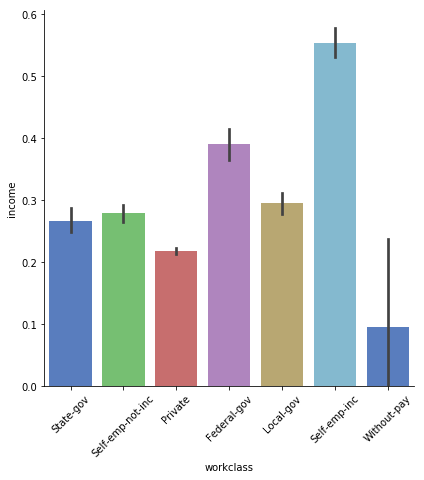

In [24]:
dff.fillna(' 0', inplace=True)

sns.factorplot(x="workclass", y="income", data=dff, kind="bar", size = 6, 
palette = "muted")
plt.xticks(rotation=45);
dff['workclass'].value_counts()

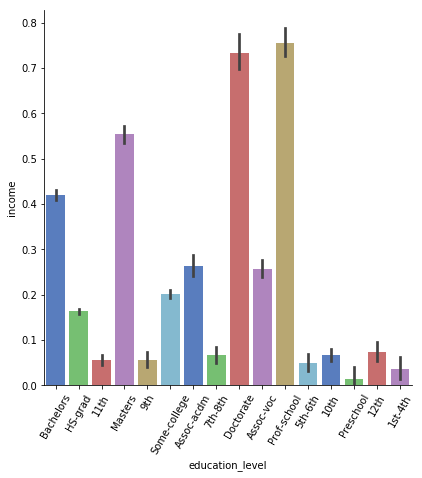

In [25]:
sns.factorplot(x="education_level",y="income",data=dff,kind="bar", size = 6, 
palette = "muted")
plt.xticks(rotation=60);

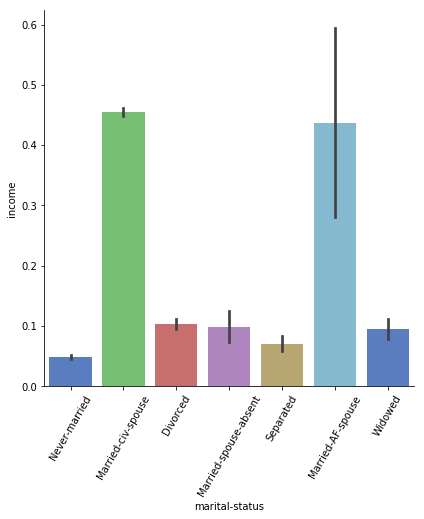

In [26]:
sns.factorplot(x="marital-status",y="income",data=dff,kind="bar", size = 6, 
palette = "muted")
plt.xticks(rotation=60);

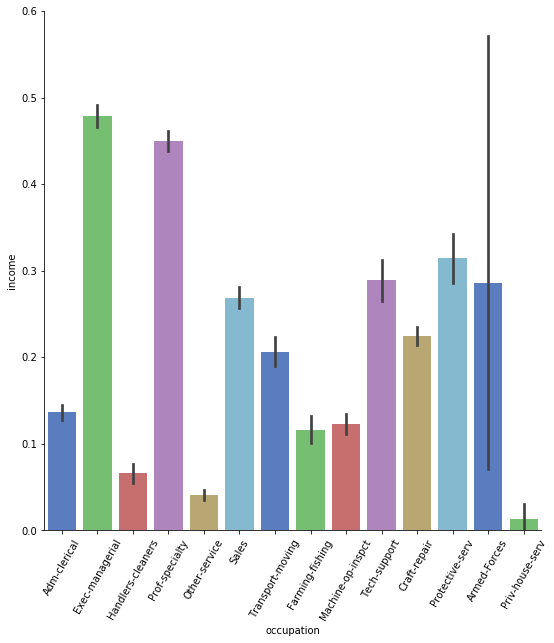

In [27]:
sns.factorplot(x="occupation",y="income",data=dff,kind="bar", size = 8, 
palette = "muted")
plt.xticks(rotation=60);

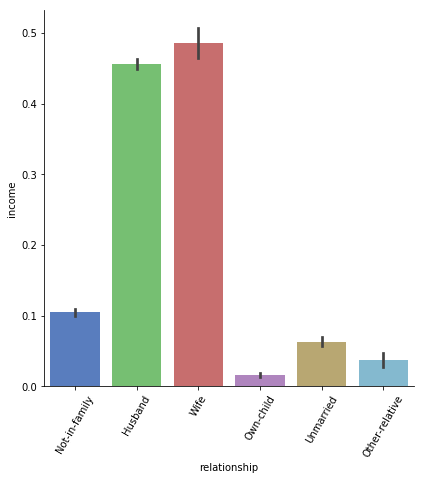

In [28]:
sns.factorplot(x="relationship",y="income",data=dff,kind="bar", size = 6, 
palette = "muted")
plt.xticks(rotation=60);

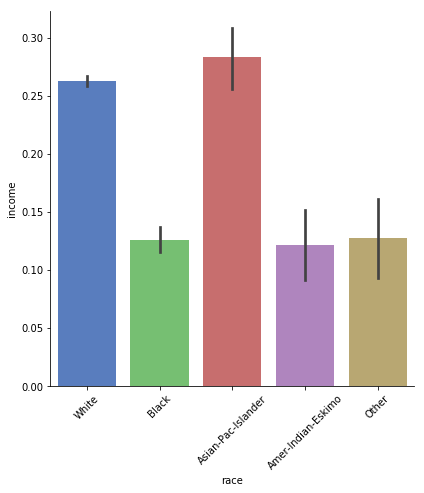

In [29]:
sns.factorplot(x="race",y="income",data=dff,kind="bar", size = 6, 
palette = "muted")
plt.xticks(rotation=45);

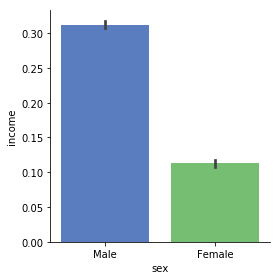

In [30]:
sns.factorplot(x="sex",y="income",data=dff,kind="bar", size = 4, 
palette = "muted");

Representamos la matriz de correlación.

In [32]:
censo.corr()

,age,education-num,capital-gain,capital-loss,hours-per-week,native-country,income,workclass:Federal-gov,workclass:Local-gov,workclass:Private,...,relationship:Own-child,relationship:Unmarried,relationship:Wife,race:Amer-Indian-Eskimo,race:Asian-Pac-Islander,race:Black,race:Other,race:White,sex:Female,sex:Male
age,1.000000,0.037623,0.079683,0.059351,0.101992,0.012082,0.237040,0.054823,0.063694,-0.209763,...,-0.418090,0.045481,0.023679,-0.016238,-0.005700,-0.013411,-0.031603,0.026604,-0.082053,0.082053
education-num,0.037623,1.000000,0.126907,0.081711,0.146206,0.132242,0.332800,0.054970,0.096524,-0.164869,...,-0.095381,-0.060224,0.035816,-0.026937,0.062534,-0.073875,-0.047719,0.051555,-0.003417,0.003417
capital-gain,0.079683,0.126907,1.000000,-0.032102,0.083880,0.010938,0.221034,-0.004223,-0.012118,-0.047957,...,-0.050407,-0.028861,0.014538,-0.007003,0.007075,-0.021538,0.000070,0.016625,-0.047444,0.047444
capital-loss,0.059351,0.081711,-0.032102,1.000000,0.054195,0.011766,0.148687,0.009106,0.009450,-0.032965,...,-0.050122,-0.035167,0.014954,-0.011622,0.002195,-0.023056,-0.006605,0.023249,-0.046457,0.046457
hours-per-week,0.101992,0.146206,0.083880,0.054195,1.000000,0.010228,0.227199,0.007387,-0.001639,-0.094559,...,-0.262845,-0.042858,-0.063452,-0.002001,-0.008182,-0.054219,-0.008875,0.052290,-0.231425,0.231425
native-country,0.012082,0.132242,0.010938,0.011766,0.010228,1.000000,0.038913,0.016367,0.034298,-0.047663,...,0.038366,-0.018600,-0.009825,0.015927,-0.371550,0.027351,-0.137654,0.186758,0.008559,-0.008559
income,0.237040,0.332800,0.221034,0.148687,0.227199,0.038913,1.000000,0.059174,0.029731,-0.116721,...,-0.222635,-0.147262,0.121396,-0.028762,0.014102,-0.090405,-0.024727,0.083481,-0.215760,0.215760
workclass:Federal-gov,0.054823,0.054970,-0.004223,0.009106,0.007387,0.016367,0.059174,1.000000,-0.048596,-0.299500,...,-0.038914,0.013721,-0.002434,0.025422,0.013320,0.053631,-0.001412,-0.058257,-0.003233,0.003233
workclass:Local-gov,0.063694,0.096524,-0.012118,0.009450,-0.001639,0.034298,0.029731,-0.048596,1.000000,-0.453573,...,-0.030987,0.030086,0.032779,0.031542,-0.016385,0.041232,-0.012130,-0.032517,0.044217,-0.044217
workclass:Private,-0.209763,-0.164869,-0.047957,-0.032965,-0.094559,-0.047663,-0.116721,-0.299500,-0.453573,1.000000,...,0.103880,0.014281,-0.020573,-0.021800,-0.001407,0.005687,0.021679,-0.003463,0.064823,-0.064823


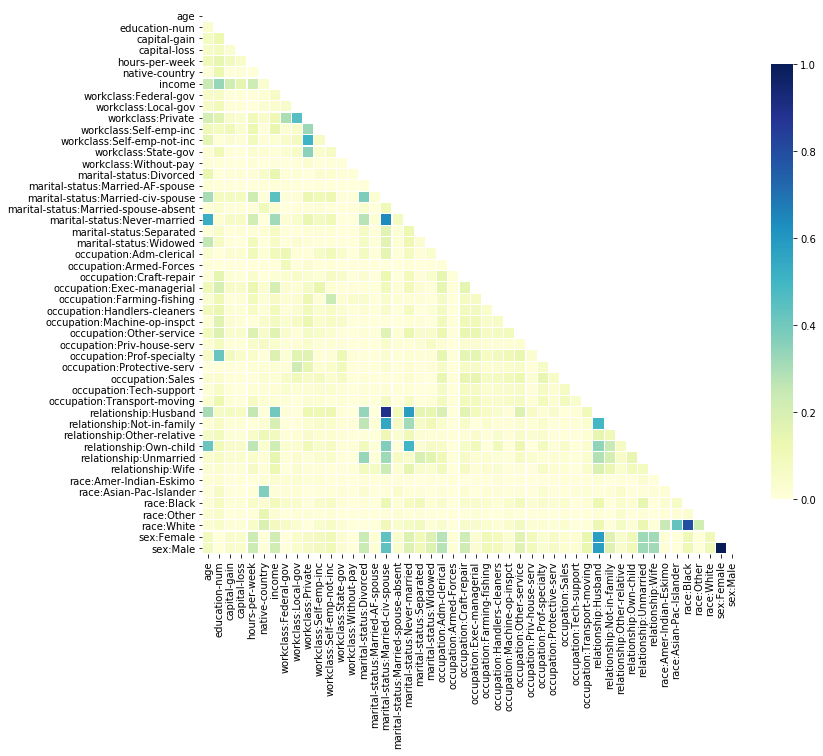

In [33]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(censo.corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

Ahora podemos crear nuestros datasets de "training" y "test".

In [36]:
X = np.array(censo.drop(['income'], 1))
y = np.array(censo['income'])
X = preprocessing.scale(X)
y = np.array(censo['income'])

#Splitting data as train and test data 
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

Empezamos a probar nuestro modelo: regresión logística, lineal, KNN, árboles de decisión, SVM, KMeans y, por último, un boosted-tree.

In [37]:
#########LOGISTIC REGRESSION######################################################

from sklearn.metrics import accuracy_score
lrn = LogisticRegression(penalty = 'l1', C = .001, class_weight='balanced')

lrn.fit(X_train, y_train)
y_pred = lrn.predict(X_test)

##########Results
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
LRA = accuracy_score(y_test, y_pred)
print("The Accuracy for Logistic Regression is {}".format(LRA))

[[4830 1936]
 [ 269 2010]]
             precision    recall  f1-score   support

          0       0.95      0.71      0.81      6766
          1       0.51      0.88      0.65      2279

avg / total       0.84      0.76      0.77      9045

The Accuracy for Logistic Regression is 0.7562189054726368


In [38]:
########################################LINEAR REGRESSION#######################

from sklearn import linear_model
from sklearn.metrics import accuracy_score

lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
y_lmpre = lm.predict(X_test)

ylm = np.around(y_lmpre)

lm.score(X_train, y_train)
lm.coef_
lm.intercept_

##########Results

print(confusion_matrix(y_test,ylm))
print(classification_report(y_test,ylm))

LA = accuracy_score(y_test, ylm)
print("The Accuracy for Linear Regression is {}".format(LA))

[[6365  401    0]
 [1076 1174   29]
 [   0    0    0]]
             precision    recall  f1-score   support

        0.0       0.86      0.94      0.90      6766
        1.0       0.75      0.52      0.61      2279
        2.0       0.00      0.00      0.00         0

avg / total       0.83      0.83      0.82      9045

The Accuracy for Linear Regression is 0.8334991708126036


C:\Users\PC-CASA\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [39]:
############################################## KNN ###############

from sklearn import preprocessing, cross_validation, neighbors
from sklearn.metrics import accuracy_score

clf = neighbors.KNeighborsClassifier()

clf.fit(X_train, y_train)

knnpre = clf.predict(X_test)

##########Results

print(confusion_matrix(y_test,knnpre))
print(classification_report(y_test,knnpre))
KKNA = accuracy_score(y_test, knnpre)
print("The Accuracy for KNN is {}".format(KKNA))

[[6140  626]
 [ 984 1295]]
             precision    recall  f1-score   support

          0       0.86      0.91      0.88      6766
          1       0.67      0.57      0.62      2279

avg / total       0.81      0.82      0.82      9045

The Accuracy for KNN is 0.8220011055831952


In [40]:
################################ Decision tree ###########################################

from sklearn.tree import DecisionTreeClassifier, export_graphviz, export
from sklearn import metrics

clf_tree = DecisionTreeClassifier( max_depth = 4 )

clf_tree.fit( X_train, y_train )
tree_predict = clf_tree.predict( X_test )
metrics.accuracy_score( y_test, tree_predict )

print(confusion_matrix(y_test,tree_predict))
print(classification_report(y_test,tree_predict))
DTA = accuracy_score(y_test, tree_predict)
print("The Accuracy for Decision Tree Model is {}".format(DTA))

[[6414  352]
 [1131 1148]]
             precision    recall  f1-score   support

          0       0.85      0.95      0.90      6766
          1       0.77      0.50      0.61      2279

avg / total       0.83      0.84      0.82      9045

The Accuracy for Decision Tree Model is 0.8360420121614152


In [41]:
################################ SVM #####################################

from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV

svc = SVC(C = 1.0, kernel = "linear" )
svc.fit( X_train, y_train )
svc_predict = svc.predict( X_test )

print(confusion_matrix(y_test,svc_predict))
print(classification_report(y_test,svc_predict))
SVMA = accuracy_score(y_test, svc_predict)
print("The Accuracy for SVM is {}".format(SVMA))

C:\Users\PC-CASA\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


[[6298  468]
 [ 919 1360]]
             precision    recall  f1-score   support

          0       0.87      0.93      0.90      6766
          1       0.74      0.60      0.66      2279

avg / total       0.84      0.85      0.84      9045

The Accuracy for SVM is 0.8466556108347153


In [42]:
########################### KMEANS ###################################

from sklearn import cluster
k_means = cluster.KMeans(n_clusters=2)
k_means.fit(X_train) 
labels = k_means.labels_
centroids  = k_means.cluster_centers_.squeeze()
labelspre = k_means.predict(X_test)
print(confusion_matrix(y_test,labelspre))
print(classification_report(y_test,labelspre))
KmeanA = accuracy_score(y_test, labelspre)
print("The Accuracy for kmeans is {}".format(KmeanA))

[[4752 2014]
 [ 542 1737]]
             precision    recall  f1-score   support

          0       0.90      0.70      0.79      6766
          1       0.46      0.76      0.58      2279

avg / total       0.79      0.72      0.73      9045

The Accuracy for kmeans is 0.7174129353233831


In [43]:
############################ Boosted Trees #################

from sklearn.ensemble import GradientBoostingClassifier

Niterations = [25,50,75,100,125,150,175,200,300]
learningRate = [0.5,0.1,0.05,0.01]
# mantenemos max_depth estático: max_depth=2

param_grid = {'n_estimators': Niterations,'learning_rate':learningRate }
grid = GridSearchCV(GradientBoostingClassifier(random_state=0, max_depth=2), param_grid=param_grid, cv = 5)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

best mean cross-validation score: 0.872
best parameters: {'learning_rate': 0.5, 'n_estimators': 125}


In [44]:
#######################XGB experiementing with learning rate
#This code is to let algorithm figure out itself, which value for learning rate is best 

import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

model = xgb.XGBClassifier()
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(learning_rate=learning_rate)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

In [45]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.282540 using {'learning_rate': 0.3}
-0.687851 (0.000040) with: {'learning_rate': 0.0001}
-0.644471 (0.000408) with: {'learning_rate': 0.001}
-0.434649 (0.002769) with: {'learning_rate': 0.01}
-0.299717 (0.004983) with: {'learning_rate': 0.1}
-0.286451 (0.005743) with: {'learning_rate': 0.2}
-0.282540 (0.005760) with: {'learning_rate': 0.3}


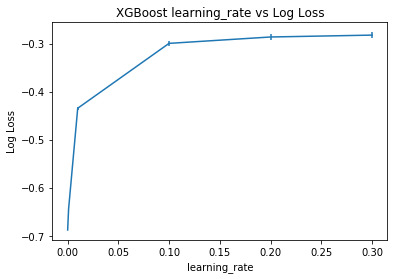

In [46]:
from matplotlib import pyplot
# plot
pyplot.errorbar(learning_rate, means, yerr=stds)
pyplot.title("XGBoost learning_rate vs Log Loss")
pyplot.xlabel('learning_rate')
pyplot.ylabel('Log Loss')
pyplot.savefig('learning_rate.png')

Best: -0.277932 using {'learning_rate': 0.2, 'n_estimators': 400}
-0.687851 (0.000040) with: {'learning_rate': 0.0001, 'n_estimators': 100}
-0.682658 (0.000080) with: {'learning_rate': 0.0001, 'n_estimators': 200}
-0.677565 (0.000121) with: {'learning_rate': 0.0001, 'n_estimators': 300}
-0.672568 (0.000163) with: {'learning_rate': 0.0001, 'n_estimators': 400}
-0.667665 (0.000205) with: {'learning_rate': 0.0001, 'n_estimators': 500}
-0.644471 (0.000408) with: {'learning_rate': 0.001, 'n_estimators': 100}
-0.604004 (0.000770) with: {'learning_rate': 0.001, 'n_estimators': 200}
-0.570057 (0.001091) with: {'learning_rate': 0.001, 'n_estimators': 300}
-0.541239 (0.001372) with: {'learning_rate': 0.001, 'n_estimators': 400}
-0.516625 (0.001646) with: {'learning_rate': 0.001, 'n_estimators': 500}
-0.434649 (0.002769) with: {'learning_rate': 0.01, 'n_estimators': 100}
-0.365300 (0.003850) with: {'learning_rate': 0.01, 'n_estimators': 200}
-0.338302 (0.004346) with: {'learning_rate': 0.01, 'n_e

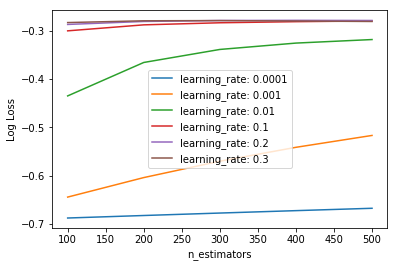

In [47]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import matplotlib
import numpy
from matplotlib import pyplot
from pandas import read_csv
# grid search
model = XGBClassifier()
n_estimators = [100, 200, 300, 400, 500]
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot results
scores = numpy.array(means).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
    pyplot.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
pyplot.legend()
pyplot.xlabel('n_estimators')
pyplot.ylabel('Log Loss')
pyplot.savefig('n_estimators_vs_learning_rate.png')